# **Fine-tuning XLSR-Wav2Vec2 for Multi-Lingual ASR with 🤗 Transformers**

### based on the turkish example

Locally my dataset is `nahuatl_slr90_by_sentence` but it should be `nahuatl_slr92_by_sentence`.

There are some **nahuatl notes**, also I filtered samples between 1 and 3 seconds to not fall in some problems of resampling or normalization of loudness, but at end did skip normalization because some samples sounded weird (not all).



Wav2Vec2 is a pretrained model for Automatic Speech Recognition (ASR) and was released in [September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) by Alexei Baevski, Michael Auli, and Alex Conneau.  Soon after the superior performance of Wav2Vec2 was demonstrated on the English ASR dataset LibriSpeech, *Facebook AI* presented XLSR-Wav2Vec2 (click [here](https://arxiv.org/abs/2006.13979)). XLSR stands for *cross-lingual  speech representations* and refers to XLSR-Wav2Vec2`s ability to learn speech representations that are useful across multiple languages.

Similar to Wav2Vec2, XLSR-Wav2Vec2 learns powerful speech representations from hundreds of thousands of hours of speech in more than 50 languages of unlabeled speech. Similar, to [BERT's masked language modeling](http://jalammar.github.io/illustrated-bert/), the model learns contextualized speech representations by randomly masking feature vectors before passing them to a transformer network.

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/xlsr_wav2vec2.png)

The authors show for the first time that massively pretraining an ASR model on cross-lingual unlabeled speech data, followed by language-specific fine-tuning on very little labeled data achieves state-of-the-art results. See Table 1-5 of the official [paper](https://arxiv.org/pdf/2006.13979.pdf).

In this notebook, we will give an in-detail explanation of how XLSR-Wav2Vec2's pretrained checkpoint can be fine-tuned on a low-resource ASR dataset of any language. Note that in this notebook, we will fine-tune XLSR-Wav2Vec2 without making use of a language model. It is much simpler and more efficient to use XLSR-Wav2Vec2 without a language model, but better results can be achieved by including a language model. 

For demonstration purposes, we fine-tune the [wav2vec2-large-xlsr-53](https://huggingface.co/facebook/wav2vec2-large-xlsr-53) on the low resource Turkish ASR dataset of [Common Voice](https://huggingface.co/datasets/common_voice) that contains just ~6h of validated training data.

XLSR-Wav2Vec2 is fine-tuned using Connectionist Temporal Classification (CTC), which is an algorithm that is used to train neural networks for sequence-to-sequence problems and mainly in Automatic Speech Recognition and handwriting recognition. 

I highly recommend reading the blog post [Sequence Modeling with CTC (2017)](https://distill.pub/2017/ctc/) very well-written blog post by Awni Hannun.

Before we start, let's install both `datasets` and `transformers` from master. Also, we need the `torchaudio` and `librosa` package to load audio files and the `jiwer` to evaluate our fine-tuned model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric ${}^1$.

In [1]:
# %%capture
# !pip install datasets==1.4.1
# # !pip install transformers==4.4.0
# !pip install torchaudio
# !pip install librosa
# !pip install jiwer

In [2]:
# %%capture
# !pip install git+https://github.com/huggingface/transformers.git

In [3]:
# %%capture
# !pip install wandb --upgrade

In [4]:
import os
import wandb

# W&B company account
%env WANDB_ENTITY = wandb
entity = os.environ["WANDB_ENTITY"]

# Choose the public W&B project
%env WANDB_PROJECT = xlsr-nahuatl
project_name = os.environ["WANDB_PROJECT"]

# Log your trained model to W&B as an Artifact
%env WANDB_LOG_MODEL = true 

env: WANDB_ENTITY=wandb
env: WANDB_PROJECT=xlsr-nahuatl
env: WANDB_LOG_MODEL=true





---

${}^1$ In the [paper](https://arxiv.org/pdf/2006.13979.pdf), the model was evaluated using the phoneme error rate (PER), but by far the most common metric in ASR is the word error rate (WER). To keep this notebook as general as possible we decided to evaluate the model using WER.

In [5]:
wandb.login()

wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


True

## Prepare Data, Tokenizer, Feature Extractor

ASR models transcribe speech to text, which means that we both need a feature extractor that processes the speech signal to the model's input format, *e.g.* a feature vector, and a tokenizer that processes the model's output format to text. 

In 🤗 Transformers, the XLSR-Wav2Vec2 model is thus accompanied by both a tokenizer, called [Wav2Vec2CTCTokenizer](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2ctctokenizer), and a feature extractor, called [Wav2Vec2FeatureExtractor](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2featureextractor).

Let's start by creating the tokenizer responsible for decoding the model's predictions.

### Create Wav2Vec2CTCTokenizer

The [pretrained Wav2Vec2 checkpoint]( ) maps the speech signal to a sequence of context representations as illustrated in the figure above. A fine-tuned XLSR-Wav2Vec2 checkpoint needs to map this sequence of context representations to its corresponding transcription so that a linear layer has to be added on top of the transformer block (shown in yellow). This linear layer is used to classifies each context representation to a token class analogous how, *e.g.*, after pretraining a linear layer is added on top of BERT's embeddings for further classification - *cf.* with *"BERT"* section of this [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder).

The output size of this layer corresponds to the number of tokens in the vocabulary, which does **not** depend on XLSR-Wav2Vec2's pretraining task, but only on the labeled dataset used for fine-tuning. So in the first step, we will take a look at Common Voice and define a vocabulary based on the dataset's transcriptions.

First, let's go to [Common Voice](https://commonvoice.mozilla.org/en/datasets) and pick a language to fine-tune XLSR-Wav2Vec2 on. For this notebook, we will use Turkish. 

For each language-specific dataset, you can find a language code corresponding to your chosen language. On [Common Voice](https://commonvoice.mozilla.org/en/datasets), look for the field "Version". The language code then corresponds to the prefix before the underscore. For Turkish, *e.g.* the language code is `"tr"`.

Great, now we can use 🤗 Datasets' simple API to download the data. The dataset name will be `"common_voice"`, the config name corresponds to the language code - `"tr"` in our case.

Common Voice has many different splits including `invalidated`, which refers to data that was not rated as "clean enough" to be considered useful. In this notebook, we will only make use of the splits `"train"`, `"validation"` and `"test"`. 

Because the Turkish dataset is so small, we will merge both the validation and training data into a training dataset and simply use the test data for validation.

##### nahuatl notes

It seems that adding other languages to the trainning of the target language does help. So I have decided this time to take one and a half hour on trainning 50 epochs that means each epochs needs to be executed in around 2 minutes.

With 2000 samples, it took around 3-6 hours. So taking 15 samples per second:

* `15*60*90=81000`
* `15*60*60=54000`

##### nahuatl notes

Create a nahhuatl dataset from the csv

In [6]:
from datasets import load_dataset, load_metric, Dataset

common_voice_train = load_dataset('csv', data_files='nahuatl_slr90_by_sentence/sentences.csv', split="train")
common_voice_train

Using custom data configuration default-08b4e7b91c5bfd2a
Reusing dataset csv (/home/tyoc213/.cache/huggingface/datasets/csv/default-08b4e7b91c5bfd2a/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


Dataset({
    features: ['main_file', 'chunk', 'start', 'end', 'duration', 'path', 'has_spanish', 'sentence'],
    num_rows: 136638
})

In [7]:
import pandas as pd

ds = pd.read_csv('nahuatl_slr90_by_sentence/sentences.csv')
ds['path'] = ('nahuatl_slr90_by_sentence/'+ds['path']).replace('flac', '')

ds['duration'].sum()/60/60, ds['duration'].mean(), ds['duration'].min(), ds['duration'].max()

(176.1681610306425, 4.641500751696549, 0.1999999999999318, 211.803)

##### nahuatl note

Some audios are less than .5 seconds which `batch all {'path': 'nahuatl_slr90_by_sentence/0_109', 'sentence': 'ipa yehwa sah** '}` is `660.817-660.431=0.386` and causes this exception `ValueError: Audio must be have length greater than the block size`

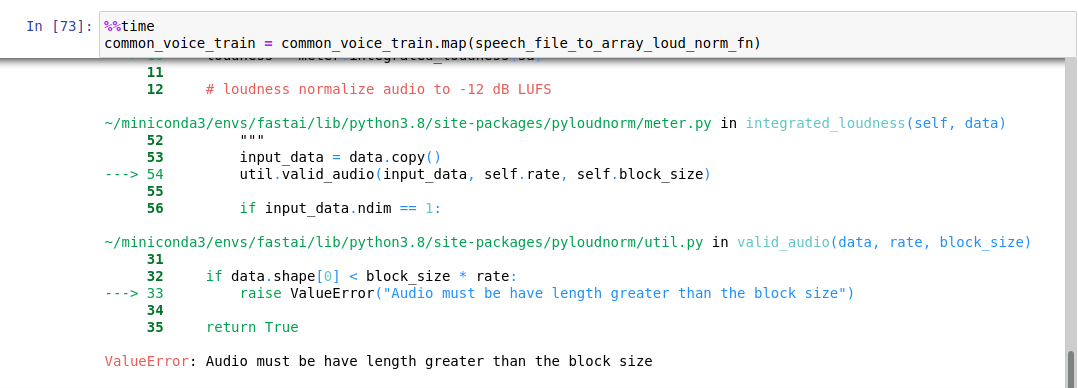

##### nahuatl note

Also filter out all the samples that has spanish in it, this will allow for only nahuatl and have less quantity of samples because processing them in `speech_file_to_array_loud_norm_fn` is slow on computer.

In [8]:
ds = pd.read_csv('nahuatl_slr90_by_sentence/sentences.csv')
ds['path'] = ('nahuatl_slr90_by_sentence/'+ds['path']).replace('flac', '')
ds = ds.loc[ds['duration'] > 1]
ds = ds.loc[ds['duration'] < 4]
ds = ds.loc[ds['has_spanish'] == 0]
ds['duration'].sum()/60/60, ds['duration'].mean(), ds['duration'].min(), ds['duration'].max()

(32.00688685763889, 2.7633832814710892, 1.0009999999999764, 3.999000000000024)

In [9]:
len(ds)

41697

In [11]:
# dsr = ds.sample(2000)
# dsr['duration'].sum()/60/60, dsr['duration'].mean(), dsr['duration'].min(), dsr['duration'].max()
dsr = ds.head(2000)
dsr_head = ds.head(1500)
dsr_tail = ds.head(500)
dsr_tail = dsr_tail.sample(100)

# use only a fraction for faster epoch time
dsr = dsr_head.sample(500)
dsr['duration'].sum()/60, dsr['duration'].mean(), dsr['duration'].min(), dsr['duration'].max()

(23.250494444449995, 2.7900593333339994, 1.027000000000001, 3.999000000000024)

##### nahuatl note

Some files have nans when resample is made...

##### nahuatl notes

Because this is not a dataset from common voice, it needs to be made as https://discuss.huggingface.co/t/how-to-combine-local-data-files-with-an-official-dataset/4685/3 and each sample is exported as json

In [12]:
#!ls /home/tyoc213/Documents/github/hf-xlsr-wav2vec2/nahuatl_slr90_by_sentence/

In [13]:
from datasets import load_dataset, load_metric

ds_train = ds[:1000]
ds_valid = ds[1500:]

common_voice_train = Dataset.from_pandas(dsr) # load_dataset("json", data_files=[f"sample_{i}.json" for i in range(0, train_total)], split="train")
common_voice_train = common_voice_train.remove_columns(['main_file', 'chunk', 'start', 'end', 'duration', 'has_spanish', '__index_level_0__'])
common_voice_test = Dataset.from_pandas(dsr_tail)  # load_dataset("json", data_files=[f"sample_{i}.json" for i in range(train_total, total_jsons)], split="train")
common_voice_test = common_voice_test.remove_columns(['main_file', 'chunk', 'start', 'end', 'duration', 'has_spanish', '__index_level_0__'])

In [14]:
%%time

import random
es = load_dataset("common_voice", "es", split="train+validation")
es = es.remove_columns(['client_id', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'])

es = es.select(random.sample(range(len(es)), k=50))

les = []
for i in range(len(es)):
    les.append({'path': es[i]['path'], 'sentence': es[i]['sentence']})

es = pd.DataFrame(les)
es = Dataset.from_pandas(es)
es

Reusing dataset common_voice (/home/tyoc213/.cache/huggingface/datasets/common_voice/es/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f)


CPU times: user 132 ms, sys: 8.86 ms, total: 141 ms
Wall time: 1.13 s


Dataset({
    features: ['path', 'sentence'],
    num_rows: 50
})

In [15]:
%%time

import random
de = load_dataset("common_voice", "de", split="train+validation")
de = de.remove_columns(['client_id', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'])

de = de.select(random.sample(range(len(de)), k=50))

lde = []
for i in range(len(de)):
    lde.append({'path': de[i]['path'], 'sentence': de[i]['sentence']})

de = pd.DataFrame(lde)
de = Dataset.from_pandas(de)
de

Reusing dataset common_voice (/home/tyoc213/.cache/huggingface/datasets/common_voice/de/6.1.0/0041e06ab061b91d0a23234a2221e87970a19cf3a81b20901474cffffeb7869f)


CPU times: user 155 ms, sys: 18.5 ms, total: 173 ms
Wall time: 870 ms


Dataset({
    features: ['path', 'sentence'],
    num_rows: 50
})

In [16]:
common_voice_train, common_voice_test

(Dataset({
     features: ['path', 'sentence'],
     num_rows: 500
 }),
 Dataset({
     features: ['path', 'sentence'],
     num_rows: 100
 }))

In [18]:
import datasets
common_voice_train = datasets.concatenate_datasets([es, de, common_voice_train])
common_voice_train, common_voice_test

(Dataset({
     features: ['path', 'sentence'],
     num_rows: 600
 }),
 Dataset({
     features: ['path', 'sentence'],
     num_rows: 100
 }))

Many ASR datasets only provide the target text, `'sentence'` for each audio file `'path'`. Common Voice actually provides much more information about each audio file, such as the `'accent'`, etc. However, we want to keep the notebook as general as possible, so that we will only consider the transcribed text for fine-tuning.



Let's write a short function to display some random samples of the dataset and run it a couple of times to get a feeling for the transcriptions.

In [19]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [20]:
show_random_elements(common_voice_train.remove_columns(["path"]), num_examples=50)

Alright! The transcriptions look fairly clean. Having translated the transcribed sentences (I'm sadly not a native speaker in Turkish), it seems that the language corresponds more to written text than noisy dialogue. This makes sense taking into account that [Common Voice](https://huggingface.co/datasets/common_voice) is a crowd-sourced read speech corpus.

We can see that the transcriptions contain some special characters, such as `,.?!;:`. Without a language model, it is much harder to classify speech chunks to such special characters because they don't really correspond to a characteristic sound unit. *E.g.*, the letter `"s"` has a more or less clear sound, whereas the special character `"."` does not.
Also in order to understand the meaning of a speech signal, it is usually not necessary to include special characters in the transcription.

In addition, we normalize the text to only have lower case letters and append a word separator token at the end.

additional chars to remove = ( ) -

##### Nahuatl note

`:` is for indicating a long vowel, we should delete that? or convert to other char? like `o: = ó`?

In [21]:
import re
#chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\(\)\-]'
chars_to_ignore_regex = '[\,\?\.\!\-\;\"\“\%\‘\”\�\(\)\-]'

def remove_special_characters(batch):
    batch["sentence"] = re.sub(chars_to_ignore_regex, '', batch["sentence"]).lower() + " "
    return batch

In [22]:
%%time
common_voice_train = common_voice_train.map(remove_special_characters)
common_voice_test = common_voice_test.map(remove_special_characters)


CPU times: user 493 ms, sys: 114 ms, total: 607 ms
Wall time: 627 ms


In [23]:
show_random_elements(common_voice_train.remove_columns(["path"]))

Good! This looks better. We have removed most special characters from transcriptions and normalized them to lower-case only.

In CTC, it is common to classify speech chunks into letters, so we will do the same here. 
Let's extract all distinct letters of the training and test data and build our vocabulary from this set of letters.

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars. 
It is important to pass the argument `batched=True` to the `map(...)` function so that the mapping function has access to all transcriptions at once.

In [24]:
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [25]:
vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)
vocab_test = common_voice_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_test.column_names)

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [26]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))

In [27]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
sorted(vocab_dict.keys())

[' ',
 "'",
 ':',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '¿',
 'ß',
 'á',
 'ä',
 'é',
 'í',
 'ñ',
 'ó',
 'ö',
 'ú',
 'ü',
 '„']

Cool, we see that all letters of the alphabet occur in the dataset (which is not really surprising) and we also extracted the special characters `" "` and `'`. Note that we did not exclude those special characters because: 

- The model has to learn to predict when a word is finished or else the model prediction would always be a sequence of chars which would make it impossible to separate words from each other.
- From the transcriptions above it seems that words that include an apostrophe, such as `maktouf'un` do exist in Turkish, so I decided to keep the apostrophe in the dataset. This might be a wrong assumption though.

One should always keep in mind that the data-preprocessing is a very important step before training your model. E.g., we don't want our model to differentiate between `a` and `A` just because we forgot to normalize the data. The difference between `a` and `A` does not depend on the "sound" of the letter at all, but more on grammatical rules - *e.g.* use a capitalized letter at the beginning of the sentence. So it is sensible to remove the difference between capitalized and non-capitalized letters so that the model has an easier time learning to transcribe speech. 

It is always advantageous to get help from a native speaker of the language you would like to transcribe to verify whether the assumptions you made are sensible, *e.g.* I should have made sure that keeping `'`, but removing other special characters is a sensible choice for Turkish. 

To make it clearer that `" "` has its own token class, we give it a more visible character `|`. In addition, we also add an "unknown" token so that the model can later deal with characters not encountered in Common Voice's training set. 

Finally, we also add a padding token that corresponds to CTC's "*blank token*". The "blank token" is a core component of the CTC algorithm. For more information, please take a look at the "Alignment" section [here](https://distill.pub/2017/ctc/).

In [28]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [29]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

45

In [30]:
vocab_dict

{'x': 0,
 'v': 1,
 ']': 2,
 'í': 3,
 ':': 4,
 'k': 5,
 'y': 6,
 'ö': 7,
 "'": 8,
 'h': 9,
 '¿': 11,
 'ñ': 12,
 'n': 13,
 'ü': 14,
 'ä': 15,
 't': 16,
 'm': 17,
 's': 18,
 'g': 19,
 'á': 20,
 'z': 21,
 'o': 22,
 'w': 23,
 '[': 24,
 'r': 25,
 'b': 26,
 'ß': 27,
 'd': 28,
 'ó': 29,
 'i': 30,
 'e': 31,
 '„': 32,
 'ú': 33,
 'c': 34,
 'f': 35,
 'p': 36,
 'a': 37,
 'l': 38,
 'q': 39,
 'j': 40,
 'u': 41,
 'é': 42,
 '|': 10,
 '[UNK]': 43,
 '[PAD]': 44}

Cool, now our vocabulary is complete and consists of 39 tokens, which means that the linear layer that we will add on top of the pretrained XLSR-Wav2Vec2 checkpoint will have an output dimension of 39.

Let's now save the vocabulary as a json file.

In [31]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to instantiate an object of the `Wav2Vec2CTCTokenizer` class.

In [32]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

Next, we will create the feature extractor.

### Create XLSR-Wav2Vec2 Feature Extractor

Speech is a continuous signal and to be treated by computers, it first has to be discretized, which is usually called **sampling**. The sampling rate hereby plays an important role in that it defines how many data points of the speech signal are measured per second. Therefore, sampling with a higher sampling rate results in a better approximation of the *real* speech signal but also necessitates more values per second.

A pretrained checkpoint expects its input data to have been sampled more or less from the same distribution as the data it was trained on. The same speech signals sampled at two different rates have a very different distribution, *e.g.*, doubling the sampling rate results in data points being twice as long. Thus, 
before fine-tuning a pretrained checkpoint of an ASR model, it is crucial to verify that the sampling rate of the data that was used to pretrain the model matches the sampling rate of the dataset used to fine-tune the model.

XLSR-Wav2Vec2 was pretrained on the audio data of [Babel](https://huggingface.co/datasets/librispeech_asr), 
[Multilingual LibriSpeech (MLS)](https://ai.facebook.com/blog/a-new-open-data-set-for-multilingual-speech-research/), and [Common Voice](https://huggingface.co/datasets/common_voice). Most of those datasets were sampled at 16kHz, so that Common Voice, sampled at 48kHz, has to be downsampled to 16kHz for training. Therefore, we will have to downsample our fine-tuning data to 16kHz in the following.



A XLSR-Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, XLSR-Wav2Vec2 models should **always** make use of the `attention_mask`.

In [33]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

Great, XLSR-Wav2Vec2's feature extraction pipeline is thereby fully defined!

To make the usage of XLSR-Wav2Vec2 as user-friendly as possible, the feature extractor and tokenizer are *wrapped* into a single `Wav2Vec2Processor` class so that one only needs a `model` and `processor` object.

In [34]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

If one wants to re-use the just created processor and the fine-tuned model of this notebook, one can mount his/her google drive to the notebook and save all relevant files there. To do so, please uncomment the following lines. 

We will give the fine-tuned model the name `"wav2vec2-large-xlsr-nahuatl-demo"`.

In [35]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [36]:
def the_name(append=''):
    MAIN_NAME = 'final0-wav2vec2-large-xlsr-nahuatl-es-de-'
    return '%s%s'%(MAIN_NAME,append)
processor.save_pretrained(the_name())

In [37]:
!ls -la wav2vec*

wav2vec2-large-xlsr-25.6m-nahuatl-es-de:
total 5296
drwxrwxr-x  2 tyoc213 tyoc213    4096 mar 28 12:14 .
drwxrwxr-x 26 tyoc213 tyoc213 5398528 mar 28 17:03 ..
-rw-rw-r--  1 tyoc213 tyoc213     158 mar 28 14:59 preprocessor_config.json
-rw-rw-r--  1 tyoc213 tyoc213      85 mar 28 14:59 special_tokens_map.json
-rw-rw-r--  1 tyoc213 tyoc213     138 mar 28 14:59 tokenizer_config.json
-rw-rw-r--  1 tyoc213 tyoc213     435 mar 28 14:59 vocab.json

wav2vec2-large-xlsr-25.6m-nahuatl-es-de-one:
total 5284
drwxrwxr-x  3 tyoc213 tyoc213    4096 mar 28 16:57 .
drwxrwxr-x 26 tyoc213 tyoc213 5398528 mar 28 17:03 ..
drwxrwxr-x  2 tyoc213 tyoc213    4096 mar 28 16:37 checkpoint-1500

wav2vec2-large-xlsr-nahuatl-1_5K-es-de:
total 5296
drwxrwxr-x  2 tyoc213 tyoc213    4096 mar 28 09:28 .
drwxrwxr-x 26 tyoc213 tyoc213 5398528 mar 28 17:03 ..
-rw-rw-r--  1 tyoc213 tyoc213     158 mar 28 09:53 preprocessor_config.json
-rw-rw-r--  1 tyoc213 tyoc213      85 mar 28 09:53 special_tokens_map.json
-rw-rw-r--  1 

Next, we can prepare the dataset.

### Preprocess Data

So far, we have not looked at the actual values of the speech signal but just kept the path to its file in the dataset. `XLSR-Wav2Vec2` expects the audio file in the format of a 1-dimensional array, so in the first step, let's load all audio files into the dataset object.

Let's first check the serialization format of the downloaded audio files by looking at the first training sample.

In [38]:
common_voice_train[0]

{'path': '/home/tyoc213/.cache/huggingface/datasets/downloads/extracted/23afbf80948a799bdd449b33e1e2dec4e2c3a6f484ca9d51877da3a04ecec770/cv-corpus-6.1-2020-12-11/es/clips/common_voice_es_20298979.mp3',
 'sentence': 'es autora de una serie de artículos históricos sobre clay county misuri '}

Alright, the audio file is saved in the `.mp3` format. The `.mp3` format is usually not the easiest format to deal with. We found that the [`torchaudio`](https://pytorch.org/audio/stable/index.html) library works best for reading in `.mp3` data. 

An audio file usually stores both its values and the sampling rate with which the speech signal was digitalized. We want to store both in the dataset and write a `map(...)` function accordingly.

In [39]:
import torchaudio

def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    batch["speech"] = speech_array[0].numpy()
    batch["sampling_rate"] = sampling_rate
    batch["target_text"] = batch["sentence"]
    return batch

In [40]:
# common_voice_train_array = common_voice_train.map(speech_file_to_array_fn, remove_columns=common_voice_train.column_names)
# common_voice_test_array = common_voice_test.map(speech_file_to_array_fn, remove_columns=common_voice_test.column_names)

## Loud Normalisation

In [41]:
import soundfile as sf
import pyloudnorm as pyln

def get_loudness_normalised(sa, sr):
    # peak normalize audio to -1 dB
    peak_normalized_audio = pyln.normalize.peak(sa, -1.0)

    # measure the loudness first 
    meter = pyln.Meter(sr) # create BS.1770 meter
    loudness = meter.integrated_loudness(sa)

    # loudness normalize audio to -12 dB LUFS
    loudness_normalized_audio = pyln.normalize.loudness(sa, loudness, -12.0)

    return loudness_normalized_audio

In [42]:
def speech_file_to_array_loud_norm_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
#     print('batch all',batch) # just to see which one is causing exceptions
    
    # DO loudness normalisation
    sa = get_loudness_normalised(speech_array[0].numpy(), sampling_rate)
    
    batch["speech"] = sa
    batch["sampling_rate"] = sampling_rate
    batch["target_text"] = batch["sentence"]
    return batch

#### Only normalise Train set

In [43]:
common_voice_train[99],common_voice_train[100],

({'path': '/home/tyoc213/.cache/huggingface/datasets/downloads/extracted/27bd561157b7c36fa5c2e7638cb225ed76cb912aa0c4727171bcc12570c16c1c/cv-corpus-6.1-2020-12-11/de/clips/common_voice_de_21623135.mp3',
  'sentence': 'darüber besteht überall klarheit '},
 {'path': 'nahuatl_slr90_by_sentence/28_85.flac',
  'sentence': 'de se: kiteki ihkó:n '})

In [44]:
%%time
##### nahuatl no normalization of loudness
#common_voice_train = common_voice_train.map(speech_file_to_array_loud_norm_fn, num_proc=2)
common_voice_train = common_voice_train.map(speech_file_to_array_fn)


CPU times: user 8.77 s, sys: 1.63 s, total: 10.4 s
Wall time: 10.9 s


In [45]:
%%time
common_voice_test = common_voice_test.map(speech_file_to_array_fn)


CPU times: user 1.33 s, sys: 185 ms, total: 1.52 s
Wall time: 1.52 s


Great, now we've successfully read in all the audio files, but since we know that Common Voice is sampled at 48kHz, we need to resample the audio files to 16kHz. 

Let's make use of the [`librosa`](https://github.com/librosa/librosa) library to downsample the data.

In [46]:
import librosa
import numpy as np

def resample(batch):
#     print(len(batch['speech']), type(batch['speech']))
#     print(batch['path'])
#     print(batch['target_text'])
    # nahuatl note: make nans zero!!!! (that is correct?)
    arr = np.asarray(batch["speech"])
    arr[np.isnan(arr)] = 0
    batch["speech"] = librosa.resample(arr, 48_000, 16_000)
    batch["sampling_rate"] = 16_000
    return batch

In [47]:
%%time
common_voice_train = common_voice_train.map(resample, num_proc=4)






CPU times: user 1.89 s, sys: 2.61 s, total: 4.5 s
Wall time: 35.2 s


In [48]:
%%time
common_voice_test = common_voice_test.map(resample, num_proc=4)





CPU times: user 356 ms, sys: 430 ms, total: 787 ms
Wall time: 5.76 s


In [49]:
print('ok')

ok


This seemed to have worked! Let's listen to a couple of audio files to better understand the dataset and verify that the audio was correctly loaded. 

**Note**: *You can click the following cell a couple of times to listen to different speech samples.*

In [50]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(common_voice_train)-1)

ipd.Audio(data=np.asarray(common_voice_train[rand_int]["speech"]), autoplay=True, rate=16000)

In [51]:
common_voice_train[rand_int]["path"]

'nahuatl_slr90_by_sentence/5_78.flac'

It can be heard, that the speakers change along with their speaking rate, accent, and background environment, etc. Overall, the recordings sound acceptably clear though, which is to be expected from a crowd-sourced read speech corpus.

Let's do a final check that the data is correctly prepared, by printing the shape of the speech input, its transcription, and the corresponding sampling rate.

**Note**: *You can click the following cell a couple of times to verify multiple samples.*

In [52]:
rand_int = random.randint(0, len(common_voice_train)-1)

print("Target text:", common_voice_train[rand_int]["target_text"])
print("Input array shape:", np.asarray(common_voice_train[rand_int]["speech"]).shape)
print("Sampling rate:", common_voice_train[rand_int]["sampling_rate"])

Target text: duró diez años en el trono 
Input array shape: (53376,)
Sampling rate: 16000


Good! Everything looks fine - the data is a 1-dimensional array, the sampling rate always corresponds to 16kHz, and the target text is normalized.

Finally, we can process the dataset to the format expected by the model for training. We will again make use of the `map(...)` function.

First, we check that the data samples have the same sampling rate of 16kHz.
Second, we extract the `input_values` from the loaded audio file. In our case, this includes only normalization, but for other speech models, this step could correspond to extracting, *e.g.* [Log-Mel features](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). 
Third, we encode the transcriptions to label ids.

**Note**: This mapping function is a good example of how the `Wav2Vec2Processor` class should be used. In "normal" context, calling `processor(...)` is redirected to `Wav2Vec2FeatureExtractor`'s call method. When wrapping the processor into the `as_target_processor` context, however, the same method is redirected to `Wav2Vec2CTCTokenizer`'s call method.
For more information please check the [docs](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#transformers.Wav2Vec2Processor.__call__).

In [53]:
def prepare_dataset(batch):
    # check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."

    batch["input_values"] = processor(batch["speech"], sampling_rate=batch["sampling_rate"][0]).input_values
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

In [54]:
common_voice_train = common_voice_train.map(prepare_dataset, remove_columns=common_voice_train.column_names, batch_size=8, num_proc=4, batched=True)
common_voice_test = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names, batch_size=8, num_proc=4, batched=True)

/home/tyoc213/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/tyoc213/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/tyoc213/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-o

/home/tyoc213/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/tyoc213/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/tyoc213/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-o

## Training

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, XLSR-Wav2Vec2 has a much larger input length than output length. *E.g.*, a sample of input length 50000 has an output length of no more than 100. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning XLSR-Wav2Vec2 requires a special padding data collator, which we will define below

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them (again making use of XLSR-Wav2Vec2's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [55]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [56]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True,
                                          pad_to_multiple_of=8, pad_to_multiple_of_labels=8)

Next, the evaluation metric is defined. As mentioned earlier, the 
predominant metric in ASR is the word error rate (WER), hence we will use it in this notebook as well.

In [57]:
wer_metric = load_metric("wer")

The model will return a sequence of logit vectors:
$\mathbf{y}_1, \ldots, \mathbf{y}_m$ with $\mathbf{y}_1 = f_{\theta}(x_1, \ldots, x_n)[0]$ and $n >> m$.

A logit vector $\mathbf{y}_1$ contains the log-odds for each word in the vocabulary we defined earlier, thus $\text{len}(\mathbf{y}_i) =$ `config.vocab_size`. We are interested in the most likely prediction of the model and thus take the `argmax(...)` of the logits. Also, we transform the encoded labels back to the original string by replacing `-100` with the `pad_token_id` and decoding the ids while making sure that consecutive tokens are **not** grouped to the same token in CTC style ${}^1$.

In [58]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Now, we can load the pretrained `XLSR-Wav2Vec2` checkpoint. The tokenizer's `pad_token_id` must be to define the model's `pad_token_id` or in the case of `Wav2Vec2ForCTC` also CTC's *blank token* ${}^2$. To save GPU memory, we enable PyTorch's [gradient checkpointing](https://pytorch.org/docs/stable/checkpoint.html) and also set the loss reduction to "*mean*".

Because the dataset is quite small (~6h of training data) and because Common Voice is quite noisy, fine-tuning Facebook's [wav2vec2-large-xlsr-53 checkpoint](https://huggingface.co/facebook/wav2vec2-large-xlsr-53) seems to require some hyper-parameter tuning. Therefore, I had to play around a bit with different values for dropout, [SpecAugment](https://arxiv.org/abs/1904.08779)'s masking dropout rate, layer dropout, and the learning rate until training seemed to be stable enough. 

**Note**: When using this notebook to train XLSR-Wav2Vec2 on another language of Common Voice those hyper-parameter settings might not work very well. Feel free to adapt those depending on your use case. 

In [59]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53", 
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True, 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The first component of XLSR-Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretraining and as stated in the [paper](https://arxiv.org/pdf/2006.13979.pdf) does not need to be fine-tuned anymore. 
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [60]:
model.freeze_feature_extractor()

In a final step, we define all parameters related to training. 
To give more explanation on some of the parameters:
- `group_by_length` makes training more efficient by grouping training samples of similar input length into one batch. This can significantly speed up training time by heavily reducing the overall number of useless padding tokens that are passed through the model
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the Common Voice dataset and might be suboptimal for other speech datasets.

For more explanations on other parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

**Note**: If one wants to save the trained models in his/her google drive the commented-out `output_dir` can be used instead.

# Here starts the first training


# Here starts the first training

In [61]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=the_name('-one'),
  # output_dir="./wav2vec2-large-xlsr-nahuatl-demo",
  group_by_length=True,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  gradient_accumulation_steps=1,
  evaluation_strategy="steps",
  num_train_epochs=150,
  fp16=True,
  save_steps=25,
  eval_steps=25,
  logging_steps=5,
  learning_rate=3e-4,
  warmup_steps=200,
  save_total_limit=1,
    
  # WANDB LOGGING: 
  report_to = 'wandb',  # enable logging to W&B
  run_name = the_name('-one')+'-ie-base-50e-ovh-4-4-upgrade',   # Name your run, optional
  load_best_model_at_end = True,  # This will ensure your best model will be uploaded to W&B
  metric_for_best_model='wer',    # Load best model based on "wer", not eval loss
  greater_is_better=False,
)

Now, all instances can be passed to Trainer and we are ready to start training!

In [62]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_test,
    tokenizer=processor.feature_extractor,
)



---

${}^1$ To allow models to become independent of the speaker rate, in CTC, consecutive tokens that are identical are simply grouped as a single token. However, the encoded labels should not be grouped when decoding since they don't correspond to the predicted tokens of the model, which is why the `group_tokens=False` parameter has to be passed. If we wouldn't pass this parameter a word like `"hello"` would incorrectly be encoded, and decoded as `"helo"`.

${}^2$ The blank token allows the model to predict a word, such as `"hello"` by forcing it to insert the blank token between the two l's. A CTC-conform prediction of `"hello"` of our model would be `[PAD] [PAD] "h" "e" "e" "l" "l" [PAD] "l" "o" "o" [PAD]`.

### Training

Training will take between 180 and 240 minutes depending on the GPU allocated to this notebook. While the trained model yields somewhat satisfying results on *Common Voice*'s test data of Turkish, it is by no means an optimally fine-tuned model. The purpose of this notebook is to demonstrate how XLSR-Wav2Vec2's [checkpoint](https://huggingface.co/facebook/wav2vec2-large-xlsr-53) can be fine-tuned on a low-resource ASR dataset.

In case you want to use this google colab to fine-tune your model, you should make sure that your training doesn't stop due to inactivity. A simple hack to prevent this is to paste the following code into the console of this tab (*right mouse click -> inspect -> Console tab and insert code*).

```javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

In [63]:
trainer.train()

/home/tyoc213/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/_tensor.py:565: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:341.)
  return torch.floor_divide(self, other)
/home/tyoc213/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/nn/modules/module.py:903: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward h

TrainOutput(global_step=2850, training_loss=0.7157523092679811, metrics={'train_runtime': 11256.0194, 'train_samples_per_second': 0.253, 'total_flos': 1.3250501354353367e+19, 'epoch': 150.0, 'init_mem_cpu_alloc_delta': 60099, 'init_mem_gpu_alloc_delta': 1261939712, 'init_mem_cpu_peaked_delta': 18258, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 0, 'train_mem_gpu_alloc_delta': 5047669248, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 0})

In [64]:
%%time
wandb.finish()

CPU times: user 7.33 s, sys: 560 ms, total: 7.89 s
Wall time: 10min 17s
